# Import MNIST dataset

In [12]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Available datasets

In [13]:

# Get a list of all the methods in the class
methods = [method_name for method_name in dir(datasets) if callable(getattr(datasets, method_name))]

# Print the list of methods
print("Methods of datasets:")
for method_name in methods:
    print(method_name)

Methods of datasets:
CIFAR10
CIFAR100
CLEVRClassification
CREStereo
Caltech101
Caltech256
CarlaStereo
CelebA
Cityscapes
CocoCaptions
CocoDetection
Country211
DTD
DatasetFolder
EMNIST
ETH3DStereo
EuroSAT
FER2013
FGVCAircraft
FakeData
FallingThingsStereo
FashionMNIST
Flickr30k
Flickr8k
Flowers102
FlyingChairs
FlyingThings3D
Food101
GTSRB
HD1K
HMDB51
INaturalist
ImageFolder
ImageNet
InStereo2k
KMNIST
Kinetics
Kitti
Kitti2012Stereo
Kitti2015Stereo
KittiFlow
LFWPairs
LFWPeople
LSUN
LSUNClass
MNIST
Middlebury2014Stereo
MovingMNIST
Omniglot
OxfordIIITPet
PCAM
PhotoTour
Places365
QMNIST
RenderedSST2
SBDataset
SBU
SEMEION
STL10
SUN397
SVHN
SceneFlowStereo
Sintel
SintelStereo
StanfordCars
UCF101
USPS
VOCDetection
VOCSegmentation
VisionDataset
WIDERFace
__getattr__


# Display random training examples

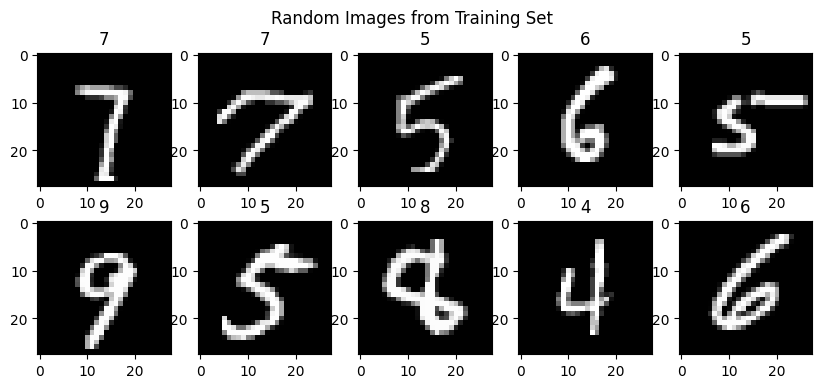

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and labels
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle('Random Images from Training Set')

for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        image = images[idx].numpy()
        label = labels[idx].numpy()
        axs[i][j].imshow(np.squeeze(image), cmap='gray')
        axs[i][j].set_title(str(label))

plt.show()

# Distance metrics

In [15]:
import numpy as np

class DistanceMetric:
    def __init__(self, num_channels=3, num_bins=256, val_range=(0, 255), epsilon=1e-10):
        self.num_channels = num_channels
        self.num_bins = num_bins
        self.val_range = val_range
        self.epsilon = epsilon

    def normalized_root_product_sum(self, hist1, hist2):
        """
        Parameters
        -------
            hist1: numpy array
            hist2: numpy array
        Example
        -------
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        img1 = mpimg.imread('horses.jpg')
        img2 = mpimg.imread('horses.jpg')
        hist1 = channel_histograms(img1)
        hist2 = channel_histograms(img2)
        normalized_root_product_sum(hist1, hist2)
        """
        intersection_sum = 0
        # Compute the sum of all bin heights
        total_bin_heights = np.sum(hist1)

        for h1, h2 in zip(hist1, hist2):
            
            # Compute the square root of the product of every bin and divide by the sum of all bin heights
            normalized_intersection = np.sum(np.sqrt(np.multiply(h1, h2)) / total_bin_heights) 
            
            intersection_sum += normalized_intersection
            
        return intersection_sum

    def channel_histograms(self, img):
        """
        Compute the histograms for each channel in the image
        Parameters
        -------
            img: uint8 numpy image array
        Example
        -------
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        img = mpimg.imread('horses.jpeg')
        channel_histograms(img)
        """
        histograms = []
        if self.val_range[0] == -1:
            img += 1 # shift values to be in range [0, 2]
     
        # Iterate over the channels in the image
        for channel in range(self.num_channels): # range(img.shape[2]):
            if self.num_channels == 1:
                channel_data = img
            else:   
                channel_data = img[:, :, channel]
            
            # Compute the histogram for the current channel
            hist, _ = np.histogram(channel_data, bins=self.num_bins)
            
            histograms.append(hist)
        # restore
        if self.val_range[0] == -1:
            img -= 1 # shift values to original range
        return histograms

    def BhattacharyaDistance(self, img1, img2):
        """
        Parameters
        -------
        img1: uint8 numpy image array
        img2: uint8 numpy image array
        Example
        -------
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        img1 = mpimg.imread('horses.jpeg')
        img2 = mpimg.imread('horses.jpeg')
        Bhattacharyya_rgb_distance(img1, img2)
        """
        hist1 = self.channel_histograms(img1)
        hist2 = self.channel_histograms(img2)
        nrps = self.normalized_root_product_sum(hist1, hist2) 
        return np.log10(self.epsilon) if nrps == 0 else -np.log10(nrps)

    def HistogramIntersection(self, img1, img2):
        """
        Parameters
        -------
        img1: uint8 numpy image array
        img2: uint8 numpy image array
        Example
        -------
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        img1 = mpimg.imread('horses.jpeg')
        img2 = mpimg.imread('horses.jpeg')
        HistogramIntersection(img1, img2)
        """   
        hist1 = self.channel_histograms(img1)
        hist2 = self.channel_histograms(img2)
        intersection_sum = 0
        for h1, h2 in zip(hist1, hist2):
            intersection_sum += np.sum(np.minimum(h1, h2))
        return intersection_sum / np.product(img1.shape)
    
    def KLDivergence(self, img1, img2):
        """
        Parameters
        -------
        img1: uint8 numpy image array
        img2: uint8 numpy image array
        Example
        -------
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        img1 = mpimg.imread('horses.jpeg')
        img2 = mpimg.imread('horses.jpeg')
        KLDivergence(img1, img2)
        """
        hist1 = self.channel_histograms(img1)
        hist2 = self.channel_histograms(img2)

        # Compute the normalization constant (sum of all bins in the first histogram)
        normalization_constant = np.product(img1.shape)

        # Compute the log of the height of all bins in the first histogram + epsilon divided by the heights of all bins in the second histogram + epsilon
        log_ratio = 0

        for h1, h2 in zip(hist1, hist2):
            log_ratio += (h1 / normalization_constant) * np.log((h1 + self.epsilon) / (h2 + self.epsilon))

        # Return the sum of the computed values
        return log_ratio.sum()

# helper functions
def get_distances_grayscale(img1, img2, num_channels=1, num_bins=256, val_range=(-1, 1)):
    """
    Compute all distances between two grayscale images
    Parameters
    -------
    img1: uint8 numpy image array
    img2: uint8 numpy image array
    Example
    -------
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img1 = mpimg.imread('horses.jpeg')
    img2 = mpimg.imread('horses.jpeg')
    get_distances_grayscale(img1, img2)
    """
    dm = DistanceMetric(num_channels=num_channels, num_bins=num_bins, val_range=val_range, epsilon=1e-10)
    return {
        'Bhattacharya': dm.BhattacharyaDistance(img1, img2),
        'HistogramIntersection': dm.HistogramIntersection(img1, img2),
        'KLDivergence': dm.KLDivergence(img1, img2)
    }

def get_distances_grayscale_labels(img1, img2, num_channels=1, num_bins=256, val_range=(-1, 1)):
    """
    Compute all distances between two grayscale images
    Parameters
    -------
    img1: uint8 numpy image array
    img2: uint8 numpy image array
    Example
    -------
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img1 = mpimg.imread('horses.jpeg')
    img2 = mpimg.imread('horses.jpeg')
    get_distances_grayscale(img1, img2)
    """
    dm = DistanceMetric(num_channels=1, num_bins=num_bins, val_range=(-1, 1), epsilon=1e-10)
    # return "{:.2f}|{:.2f}|{:.2f}".format(dm.HistogramIntersection(img1, img2), dm.KLDivergence(img1, img2), dm.BhattacharyaDistance(img1, img2))
    return "{:.2f}|{:.2f}".format(dm.KLDivergence(img1, img2), dm.BhattacharyaDistance(img1, img2))
    
    # return {
    #     'Bhattacharya': dm.BhattacharyaDistance(img1, img2),
    #     'HistogramIntersection': dm.HistogramIntersection(img1, img2),
    #     'KLDivergence': dm.KLDivergence(img1, img2)
    # }    

def get_distances_RGB(img1, img2):
    """
    Compute all distances between two RGB images
    Parameters
    -------
    img1: uint8 numpy image array
    img2: uint8 numpy image array
    Example
    -------
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img1 = mpimg.imread('horses.jpeg')
    img2 = mpimg.imread('horses.jpeg')
    get_distances_RGB(img1, img2)
    """
    dm = DistanceMetric(num_channels=3, num_bins=256, val_range=(0, 255), epsilon=1e-10)
    return {
        'Bhattacharya': dm.BhattacharyaDistance(img1, img2),
        'HistogramIntersection': dm.HistogramIntersection(img1, img2),
        'KLDivergence': dm.KLDivergence(img1, img2)
    }

def get_distances_RGB_labels(img1, img2):
    """
    Compute all distances between two RGB images
    Parameters
    -------
    img1: uint8 numpy image array
    img2: uint8 numpy image array
    Example
    -------
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img1 = mpimg.imread('horses.jpeg')
    img2 = mpimg.imread('horses.jpeg')
    get_distances_RGB(img1, img2)
    """
    dm = DistanceMetric(num_channels=3, num_bins=256, val_range=(0, 255), epsilon=1e-10)
    return "{:.2f}|{:.2f}".format(dm.KLDivergence(img1, img2), dm.BhattacharyaDistance(img1, img2))
    # return {
    #     'Bhattacharya': dm.BhattacharyaDistance(img1, img2),
    #     'HistogramIntersection': dm.HistogramIntersection(img1, img2),
    #     'KLDivergence': dm.KLDivergence(img1, img2)
    # }        

# Perturbation class - grayscale

In [16]:
import numpy as np
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

class Perturbation:
    """
    A class to apply various types of noise to grayscale images.

    Args:
        pixel_range (tuple): The range of pixel values in the image (default: (-1, 1)).
    """

    def __init__(self, pixel_range=(-1, 1)):
        self.pixel_range = pixel_range

    def add_gaussian_noise(self, image, mean=0, std=1):
        """
        Add Gaussian noise to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            mean (float): The mean of the Gaussian distribution (default: 0).
            std (float): The standard deviation of the Gaussian distribution (default: 1).

        Returns:
            ndarray: The noisy image.
        """
        h, w = image.shape
        noise = np.random.normal(mean, std, (h, w))
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, *self.pixel_range)
        return noisy_image

    def add_shot_noise(self, image, intensity=0.1):
        """
        Add shot noise to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            intensity (float): The intensity of the shot noise (default: 0.1).

        Returns:
            ndarray: The noisy image.
        """
        h, w = image.shape
        noise = np.random.poisson(intensity, (h, w))
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, *self.pixel_range)
        return noisy_image

    def add_impulse_noise(self, image, density=0.1, intensity=1):
        """
        Add impulse noise to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            density (float): The density of the impulse noise (default: 0.1).
            intensity (int): The intensity of the impulse noise (default: 1).

        Returns:
            ndarray: The noisy image.
        """
        h, w = image.shape
        noise = np.zeros((h, w), dtype=np.uint8)
        num_pixels = int(density * h * w)
        indices = np.random.choice(h * w, num_pixels, replace=False)
        noise.flat[indices] = intensity
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, *self.pixel_range)
        return noisy_image

    def add_defocus_blur(self, image, kernel_size=3, blur_amount=1.0):
        """
        Add defocus blur to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            kernel_size (int): The size of the defocus blur kernel (default: 3).
            blur_amount (float): The amount of defocus blur to apply (default: 1.0).

        Returns:
            ndarray: The blurred image.
        """
        kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / kernel_size ** 2
        blurred_image = cv2.filter2D(image, -1, kernel)
        blurred_image = blurred_image * blur_amount + image * (1 - blur_amount)
        blurred_image = np.clip(blurred_image, *self.pixel_range)
        return blurred_image      

    def add_frosted_glass_blur(self, image, kernel_size=3, sigma=1.0):
        """
        Add frosted glass blur to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            kernel_size (int): The size of the frosted glass blur kernel (default: 3).
            sigma (float): The standard deviation of the Gaussian distribution used to add noise to the kernel (default: 1.0).

        Returns:
            ndarray: The blurred image.
        """
        height, width = image.shape
        dx = cv2.randu(np.zeros((height, width), dtype=np.float32), -kernel_size, kernel_size)
        dy = cv2.randu(np.zeros((height, width), dtype=np.float32), -kernel_size, kernel_size)
        noise = np.zeros_like(image)
        cv2.randn(noise, 0, sigma)
        x_indices = np.tile(np.arange(width), (height, 1)) + dx
        y_indices = np.tile(np.arange(height).reshape(-1, 1), (1, width)) + dy
        indices = np.round(np.stack([y_indices, x_indices], axis=-1)).astype(np.int32)
        indices[:, :, 0] = np.clip(indices[:, :, 0], 0, height - 1)
        indices[:, :, 1] = np.clip(indices[:, :, 1], 0, width - 1)
        indices = indices.reshape(-1, 2)
        noisy_kernel = noise[indices[:, 0], indices[:, 1]].reshape(height, width)
        kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / kernel_size ** 2
        blurred_image = cv2.filter2D(image, -1, kernel + noisy_kernel)
        blurred_image = np.clip(blurred_image, *self.pixel_range)
        return blurred_image   

    def add_motion_blur(self, image, kernel_size=3, angle=0, direction=(1, 0)):
        """
        Add motion blur to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            kernel_size (int): The size of the motion blur kernel (default: 3).
            angle (float): The angle of the motion blur in degrees (default: 0).
            direction (tuple): The direction of the motion blur (default: (1, 0)).

        Returns:
            ndarray: The blurred image.
        """
        height, width = image.shape
        kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size, dtype=np.float32)
        kernel = cv2.warpAffine(kernel, cv2.getRotationMatrix2D((kernel_size / 2 - 0.5, kernel_size / 2 - 0.5), angle, 1.0), (kernel_size, kernel_size))
        kernel = kernel / kernel.sum()
        dx, dy = direction
        if abs(dx) > abs(dy):
            kernel = np.rot90(kernel)
        blurred_image = cv2.filter2D(image, -1, kernel)
        blurred_image = np.clip(blurred_image, *self.pixel_range)
        return blurred_image               

    def add_zoom_blur(self, image, kernel_size=3, strength=1.0):
        """
        Add zoom blur to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            kernel_size (int): The size of the zoom blur kernel (default: 3).
            strength (float): The strength of the zoom blur (default: 1.0).

        Returns:
            ndarray: The blurred image.
        """
        height, width = image.shape
        cx, cy = width / 2, height / 2
        kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
        for i in range(kernel_size):
            for j in range(kernel_size):
                dx = (j - cx) / (kernel_size / 2)
                dy = (i - cy) / (kernel_size / 2)
                d = np.sqrt(dx ** 2 + dy ** 2)
                r = d * strength
                theta = np.arctan2(dy, dx)
                kernel[i, j] = r * np.sin(theta)
        kernel = kernel / kernel.sum()
        blurred_image = cv2.filter2D(image, -1, kernel)
        blurred_image = np.clip(blurred_image, *self.pixel_range)
        return blurred_image

    def add_snow(self, image, snow_level=0.1, snow_color=1, blur_kernel_size=5, blur_sigma=1.0):
        """
        Add random snow to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            snow_level (float): The percentage of pixels to turn to snow (default: 0.1).
            snow_color (float): The color of the snow (default: 1).
            blur_kernel_size (int): The size of the Gaussian blur kernel (default: 5).
            blur_sigma (float): The standard deviation of the Gaussian blur (default: 1.0).

        Returns:
            ndarray: The snow-covered image.
        """
        height, width = image.shape
        snow_mask = np.zeros((height, width))
        snow_mask[np.random.random((height, width)) < snow_level] = 1
        snow_mask = cv2.GaussianBlur(snow_mask, (blur_kernel_size, blur_kernel_size), blur_sigma)
        snow_mask = np.clip(snow_mask, 0, 1)
        snow_image = np.zeros_like(image)
        snow_image = np.where(snow_mask == 1, snow_color, snow_image)
        noisy_image = np.clip(image + snow_image, *self.pixel_range)
        return noisy_image

    def add_frost(self, image, frost_level=0.1, frost_sigma=1.0, frost_threshold=0.1, blur_kernel_size=5, blur_sigma=1.0):
        """
        Add frost to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            frost_level (float): The percentage of pixels to turn to frost (default: 0.1).
            frost_sigma (float): The standard deviation of the Gaussian distribution used to generate the frost patterns (default: 1.0).
            frost_threshold (float): The threshold for the frost patterns (default: 0.1).
            blur_kernel_size (int): The size of the Gaussian blur kernel (default: 5).
            blur_sigma (float): The standard deviation of the Gaussian blur (default: 1.0).

        Returns:
            ndarray: The frost-covered image.
        """
        height, width = image.shape
        frost_mask = np.random.normal(loc=0.5, scale=frost_sigma, size=(height, width))
        frost_mask[frost_mask < frost_threshold] = 0
        frost_mask[frost_mask >= frost_threshold] = 1
        frost_mask = np.clip(frost_mask + np.random.normal(scale=0.1, size=(height, width)), 0, 1)
        frost_mask = cv2.GaussianBlur(frost_mask, (blur_kernel_size, blur_kernel_size), blur_sigma)
        frost_image = np.where(frost_mask == 1, np.random.normal(scale=0.1, size=(height, width)), 0)
        noisy_image = np.clip(image + frost_level * frost_image, *self.pixel_range)
        return noisy_image       

    def add_fog(self, image, fog_level=0.1, fog_density=0.5):
        """
        Add fog to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            fog_level (float): The amount of fog to add (default: 0.1).
            fog_density (float): The density of the fog (default: 0.5).

        Returns:
            ndarray: The foggy image.
        """
        height, width = image.shape
        x, y = np.meshgrid(np.arange(width), np.arange(height))
        x = (x - width/2) / (width/2)
        y = (y - height/2) / (height/2)
        dist = np.sqrt(x**2 + y**2)
        fog_mask = np.exp(-((dist/fog_density)**2))
        fog_mask = np.clip(fog_mask + np.random.normal(scale=0.1, size=(height, width)), 0, 1)
        noisy_image = np.clip(image * (1 - fog_level) + fog_mask * fog_level, *self.pixel_range)
        return noisy_image        

    def add_brightness(self, image, brightness = 0.1):
        """
        Add brightness to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            brightness_level (float): The amount of brightness to add (default: 0.1).

        Returns:
            ndarray: The brighter image.
        """
        noisy_image = np.clip(image + brightness, *self.pixel_range)
        return noisy_image  

    def add_contrast(self, image, contrast_level=0.1):
        """
        Add contrast to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            contrast_level (float): The amount of contrast to add (default: 0.1).

        Returns:
            ndarray: The image with added contrast.
        """
        mean_pixel = np.mean(image)
        noisy_image = np.clip((image - mean_pixel) * (1 + contrast_level), *self.pixel_range)
        return noisy_image    

    def add_elastic2(self, image, alpha=15, sigma=3, seed=None):
        """
        Apply an elastic transformation to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            alpha (float): The scale factor for the displacement field (default: 15).
            sigma (float): The standard deviation of the Gaussian kernel used to smooth the displacement field (default: 3).
            seed (int): The random seed to use (default: None).

        Returns:
            ndarray: The image with added elastic transformation.
        """
        if seed is not None:
            np.random.seed(seed)
        shape = image.shape[:2]
        dx = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (0, 0), sigma) * alpha
        dy = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (0, 0), sigma) * alpha
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        noisy_image = cv2.remap(image, np.float32(indices[1]), np.float32(indices[0]), interpolation=cv2.INTER_LINEAR)
        return noisy_image  
        
    def add_elastic(self, image, alpha=200, sigma=10, seed=None):
        """
        Add elastic transformations to a grayscale image.

        Args:
            image (ndarray): The grayscale image.
            alpha (float): The displacement field scale (default: 200).
            sigma (float): The displacement field smoothness (default: 10).
            seed (int): The random seed to use (default: None).

        Returns:
            ndarray: The image with elastic transformations applied.
        """
        if seed is not None:
            np.random.seed(seed)
        image_rgb = np.stack([image]*3, axis=-1)  # Convert grayscale to RGB
        h, w, _ = image_rgb.shape
        dx = np.float32(cv2.getGaussianKernel(w, sigma))
        dy = np.float32(cv2.getGaussianKernel(h, sigma))
        dx = np.outer(dx, np.ones(h))
        dy = np.outer(np.ones(w), dy)
        displacement_field = np.stack([dx, dy], axis=-1)
        displacement_field *= alpha * np.random.randn(h, w, 2)
        displacement_field -= displacement_field.min()
        displacement_field /= displacement_field.max()
        warped_image = cv2.remap(image_rgb, displacement_field[..., 1], displacement_field[..., 0], cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
        warped_image = ((warped_image - warped_image.min()) / (warped_image.max() - warped_image.min())) * (self.pixel_range[1] - self.pixel_range[0]) + self.pixel_range[0]
        return warped_image[..., 0]  # Convert back to grayscale

    def pixelate(self, image, factor=4):
        """
        Pixelate a grayscale image by replacing each pixel with the average of a square block of pixels.

        Args:
            image (ndarray): The grayscale image.
            factor (int): The factor by which to reduce the size of the image (default: 4).

        Returns:
            ndarray: The pixelated image.
        """
        h, w = image.shape
        h_new, w_new = h // factor, w // factor
        image_small = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)
        image_large = cv2.resize(image_small, (w, h), interpolation=cv2.INTER_NEAREST)
        pixelated_image = ((image_large - image_large.min()) / (image_large.max() - image_large.min())) * (self.pixel_range[1] - self.pixel_range[0]) + self.pixel_range[0]
        return pixelated_image                    

    def add_jpeg_noise(self, image, quality=80):
        """
        Add JPEG compression artifacts to an image.

        Args:
            image (ndarray): The grayscale image.
            quality (int): The JPEG compression quality (default: 80).

        Returns:
            ndarray: The image with JPEG compression artifacts added.
        """
        # Convert image to JPEG and back to simulate compression artifacts
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, buffer = cv2.imencode(".jpg", image, encode_param)
        jpeg_image = cv2.imdecode(buffer, cv2.IMREAD_GRAYSCALE)
        jpeg_image = ((jpeg_image - jpeg_image.min()) / (jpeg_image.max() - jpeg_image.min())) * (self.pixel_range[1] - self.pixel_range[0]) + self.pixel_range[0]
        return jpeg_image 

       

<ipython-input-16-2e45bcf69436>:3: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates
<ipython-input-16-2e45bcf69436>:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Apply grayscale perturbations

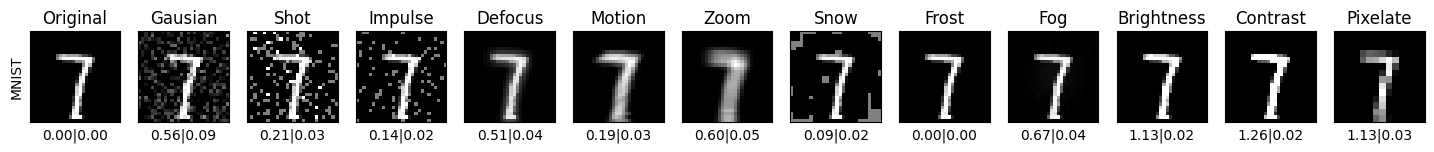

In [17]:
image = images[0].numpy()
# Squeeze the image to remove the singleton dimension
image = np.squeeze(image)
# Determine number of bins
num_bins=len(np.unique(image))

# Create a Perturbation object 
perturbation = Perturbation(pixel_range=(-1, 1))
# No noise
original_label = get_distances_grayscale_labels(image, image, num_bins=num_bins)
# Add Gaussian Noise
image_gaussian_noise = perturbation.add_gaussian_noise(image, mean=0.0, std=0.4)
image_gaussian_noise_label = get_distances_grayscale_labels(image, image_gaussian_noise, num_bins=num_bins)
# Add Shot Noise
image_shot_noise = perturbation.add_shot_noise(image, intensity=0.2)
image_shot_noise_label = get_distances_grayscale_labels(image, image_shot_noise, num_bins=num_bins)
# Add Impulse Noise
image_impulse_noise = perturbation.add_impulse_noise(image, density=0.1, intensity=1)
image_impulse_noise_label = get_distances_grayscale_labels(image, image_impulse_noise, num_bins=num_bins)
# Add Defocus Blur
image_defocus_blur = perturbation.add_defocus_blur(image, kernel_size=5, blur_amount=0.5)
image_defocus_blur_label = get_distances_grayscale_labels(image, image_defocus_blur, num_bins=num_bins)
# Add Frosted Glass Blur 
#image_frosted_glass_blur = perturbation.add_frosted_glass_blur(image, kernel_size=2, sigma=1.0)
# Add motion blur
image_motion_blur = perturbation.add_motion_blur(image, kernel_size=5, angle=30, direction=(1, 1))
image_motion_blur_label = get_distances_grayscale_labels(image, image_motion_blur, num_bins=num_bins)
# Add Zoom Blur
image_zoom_blur = perturbation.add_zoom_blur(image, kernel_size=5, strength=2.0)
image_zoom_blur_label = get_distances_grayscale_labels(image, image_zoom_blur, num_bins=num_bins)
# Add Snow
image_snow = perturbation.add_snow(image, snow_level=0.9, snow_color=1, blur_kernel_size=5, blur_sigma=1.0)
image_snow_label = get_distances_grayscale_labels(image, image_snow, num_bins=num_bins)
# Add Frost
# def add_frost(self, image, frost_level=0.1, frost_sigma=1.0, frost_threshold=0.1, blur_kernel_size=5, blur_sigma=1.0):
image_frost = noisy_image = perturbation.add_frost(image, frost_level=0.95, frost_sigma=1.0, frost_threshold=0.1, blur_kernel_size=3, blur_sigma=1.0)
image_frost_label = get_distances_grayscale_labels(image, image_frost, num_bins=num_bins)
# Add Fog
image_fog = perturbation.add_fog(image, fog_level=0.1, fog_density=0.5)
image_fog_label = get_distances_grayscale_labels(image, image_fog, num_bins=num_bins)
# Add Brigthness
image_brightness = perturbation.add_brightness(image, brightness = 0.5)
image_brightness_label = get_distances_grayscale_labels(image, image_brightness, num_bins=num_bins)
# Add contrast 
image_contrast = perturbation.add_contrast(image, contrast_level=0.1)
image_contrast_label = get_distances_grayscale_labels(image, image_contrast, num_bins=num_bins)
# Add elasticity
# image_elastic = perturbation.add_elastic(image, alpha=20, sigma=1)
# Add pixelation
image_pixelate = perturbation.pixelate(image, factor=2)
image_pixelate_label = get_distances_grayscale_labels(image, image_pixelate, num_bins=num_bins)

# Display the original and noisy images
fig, axs = plt.subplots(1, 13, figsize=(18, 3))

# 1. original
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original')
axs[0].set_xlabel(original_label)
axs[0].set_ylabel('MNIST')
axs[0].set_xticks([])
axs[0].set_yticks([])

# 2. Gaussian Noise
axs[1].imshow(image_gaussian_noise, cmap='gray')
axs[1].set_title('Gausian')
axs[1].set_xlabel(image_gaussian_noise_label)
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])

# 3. Shot Noise
axs[2].imshow(image_shot_noise, cmap='gray')
axs[2].set_title('Shot')
axs[2].set_xlabel(image_shot_noise_label)
axs[2].set_ylabel('')
axs[2].set_xticks([])
axs[2].set_yticks([])

# 4. Impulse Noise
axs[3].imshow(image_impulse_noise, cmap='gray')
axs[3].set_title('Impulse')
axs[3].set_xlabel(image_impulse_noise_label)
axs[3].set_ylabel('')
axs[3].set_xticks([])
axs[3].set_yticks([])

# 5. Defocus Blur
axs[4].imshow(image_defocus_blur, cmap='gray')
axs[4].set_title('Defocus')
axs[4].set_xlabel(image_defocus_blur_label)
axs[4].set_ylabel('')
axs[4].set_xticks([])
axs[4].set_yticks([])

# 4. Motion Blur
axs[5].imshow(image_motion_blur, cmap='gray')
axs[5].set_title('Motion')
axs[5].set_xlabel(image_motion_blur_label)
axs[5].set_ylabel('')
axs[5].set_xticks([])
axs[5].set_yticks([])

# 5. Zoom Blur
axs[6].imshow(image_zoom_blur, cmap='gray')
axs[6].set_title('Zoom')
axs[6].set_xlabel(image_zoom_blur_label)
axs[6].set_ylabel('')
axs[6].set_xticks([])
axs[6].set_yticks([])

# 6. Snow
axs[7].imshow(image_snow, cmap='gray')
axs[7].set_title('Snow')
axs[7].set_xlabel(image_snow_label)
axs[7].set_ylabel('')
axs[7].set_xticks([])
axs[7].set_yticks([])

# 7. Frost
axs[8].imshow(image_frost, cmap='gray')
axs[8].set_title('Frost')
axs[8].set_xlabel(image_frost_label)
axs[8].set_ylabel('')
axs[8].set_xticks([])
axs[8].set_yticks([])

# 8. Fog
axs[9].imshow(image_fog, cmap='gray')
axs[9].set_title('Fog')
axs[9].set_xlabel(image_fog_label)
axs[9].set_ylabel('')
axs[9].set_xticks([])
axs[9].set_yticks([])

# 9. Brightness
axs[10].imshow(image_brightness, cmap='gray')
axs[10].set_title('Brightness')
axs[10].set_xlabel(image_brightness_label)
axs[10].set_ylabel('')
axs[10].set_xticks([])
axs[10].set_yticks([])

# 10. Contrast
axs[11].imshow(image_contrast, cmap='gray')
axs[11].set_title('Contrast')
axs[11].set_xlabel(image_contrast_label)
axs[11].set_ylabel('')
axs[11].set_xticks([])
axs[11].set_yticks([])

# 11. Pixelate
axs[12].imshow(image_pixelate, cmap='gray')
axs[12].set_title('Pixelate')
axs[12].set_xlabel(image_pixelate_label)
axs[12].set_ylabel('')
axs[12].set_xticks([])
axs[12].set_yticks([])

# omit axis labels
#for ax in axs:
#    ax.axis('off')

plt.show()

# Import the CIFAR10 dataset

In [18]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data
trainset2 = datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=transform)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=64, shuffle=True)

# Download and load the test data
testset2 = datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transform)
testloader2 = torch.utils.data.DataLoader(testset2, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 49091759.54it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


# Display random CIFAR10 training examples

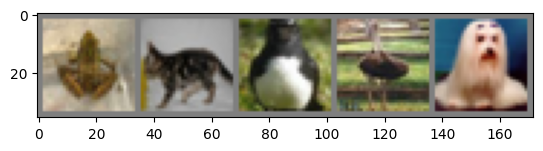

In [21]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get 5 random images from the training dataset
dataiter2 = iter(trainloader2)
images_rgb, labels = next(dataiter2)
random_indices = np.random.choice(range(64), size=5, replace=False)
random_images = torch.index_select(images_rgb, 0, torch.tensor(random_indices))

# Show images
imshow(torchvision.utils.make_grid(random_images))


# Perturbation class - RGB

In [20]:
import numpy as np
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import zoom as scizoom

class PerturbationRGB:
    """
    A class to apply various types of noise to RGB images.

    Args:
        pixel_range (tuple): The range of pixel values in the image (default: (0, 1)).
    """

    def __init__(self, pixel_range=(0, 1)):
        self.pixel_range = pixel_range

    def add_gaussian_noise(self, image, mean=0, std=1):
        """
        Add Gaussian noise to an RGB image.

        Args:
            image (ndarray): The RGB image.
            mean (float): The mean of the Gaussian distribution (default: 0).
            std (float): The standard deviation of the Gaussian distribution (default: 1).

        Returns:
            ndarray: The noisy image.
        """
        h, w, c = image.shape
        noise = np.random.normal(mean, std, (h, w, c))
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, *self.pixel_range)
        return noisy_image

    def add_shot_noise(self, image, intensity=0.1):
        """
        Add shot noise to an RGB image.

        Args:
            image (ndarray): The RGB image.
            intensity (float): The intensity of the shot noise (default: 0.1).

        Returns:
            ndarray: The noisy image.
        """
        h, w, c = image.shape
        noise = np.random.poisson(intensity, (h, w, c))
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, *self.pixel_range)
        return noisy_image       

    def add_impulse_noise(self, image, density=0.1, intensity=1):
        """
        Add impulse noise to an RGB image.

        Args:
            image (ndarray): The RGB image.
            density (float): The density of the impulse noise (default: 0.1).
            intensity (int): The intensity of the impulse noise (default: 1).

        Returns:
            ndarray: The noisy image.
        """
        h, w, c = image.shape
        noise = np.zeros((h, w, c), dtype=np.uint8)
        num_pixels = int(density * h * w * c)
        indices = np.random.choice(h * w * c, num_pixels, replace=False)
        noise.flat[indices] = intensity
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, 0, 1)
        return noisy_image

    def add_defocus_blur(self, image, kernel_size=3, blur_amount=1.0):
        """
        Add defocus blur to an RGB image.

        Args:
            image (ndarray): The RGB image.
            kernel_size (int): The size of the defocus blur kernel (default: 3).
            blur_amount (float): The amount of defocus blur to apply (default: 1.0).

        Returns:
            ndarray: The blurred image.
        """
        kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / kernel_size ** 2
        blurred_image = cv2.filter2D(image, -1, kernel)
        blurred_image = blurred_image * blur_amount + image * (1 - blur_amount)
        blurred_image = np.clip(blurred_image, *self.pixel_range)
        return blurred_image   

    def add_frosted_glass_blur(self, image, kernel_size=3, sigma=1.0):
        """
        Add frosted glass blur to an RGB image.

        Args:
            image (ndarray): The RGB image.
            kernel_size (int): The size of the frosted glass blur kernel (default: 3).
            sigma (float): The standard deviation of the Gaussian distribution used to add noise to the kernel (default: 1.0).

        Returns:
            ndarray: The blurred image.
        """
        height, width, channels = image.shape
        dx = cv2.randu(np.zeros((height, width, channels), dtype=np.float32), -kernel_size, kernel_size)
        dy = cv2.randu(np.zeros((height, width, channels), dtype=np.float32), -kernel_size, kernel_size)
        noise = np.zeros_like(image)
        cv2.randn(noise, 0, sigma)
        x_indices = np.tile(np.arange(width), (height, 1, channels)) + dx
        y_indices = np.tile(np.arange(height).reshape(-1, 1, 1), (1, width, channels)) + dy
        indices = np.round(np.stack([y_indices, x_indices], axis=-1)).astype(np.int32)
        indices[:, :, :, 0] = np.clip(indices[:, :, :, 0], 0, height - 1)
        indices[:, :, :, 1] = np.clip(indices[:, :, :, 1], 0, width - 1)
        indices = indices.reshape(-1, 2, channels)
        noisy_kernel = noise[indices[:, 0], indices[:, 1]].reshape(height, width, channels)
        kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / kernel_size ** 2
        blurred_image = np.empty_like(image)
        for ch in range(channels):
            blurred_image[:, :, ch] = cv2.filter2D(image[:, :, ch], -1, kernel + noisy_kernel[:, :, ch])
        blurred_image = np.clip(blurred_image, *self.pixel_range)
        return blurred_image 

    def add_motion_blur(self, image, kernel_size=3, angle=0, direction=(1, 0)):
        """
        Add motion blur to an RGB image.

        Args:
            image (ndarray): The RGB image.
            kernel_size (int): The size of the motion blur kernel (default: 3).
            angle (float): The angle of the motion blur in degrees (default: 0).
            direction (tuple): The direction of the motion blur (default: (1, 0)).

        Returns:
            ndarray: The blurred image.
        """
        height, width, channels = image.shape
        kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size, dtype=np.float32)
        kernel = cv2.warpAffine(kernel, cv2.getRotationMatrix2D((kernel_size / 2 - 0.5, kernel_size / 2 - 0.5), angle, 1.0), (kernel_size, kernel_size))
        kernel = kernel / kernel.sum()
        dx, dy = direction
        if abs(dx) > abs(dy):
            kernel = np.rot90(kernel)
        blurred_image = np.empty_like(image)
        for ch in range(channels):
            blurred_image[:, :, ch] = cv2.filter2D(image[:, :, ch], -1, kernel)
        blurred_image = np.clip(blurred_image, *self.pixel_range)
        return blurred_image  

    def add_zoom_blur(self, image, kernel_size=3, strength=1.0):
        """
        Add zoom blur to an RGB image.

        Args:
            image (ndarray): The RGB image.
            kernel_size (int): The size of the zoom blur kernel (default: 3).
            strength (float): The strength of the zoom blur (default: 1.0).

        Returns:
            ndarray: The blurred image.
        """
        height, width, channels = image.shape
        cx, cy = width / 2, height / 2
        kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
        for i in range(kernel_size):
            for j in range(kernel_size):
                dx = (j - cx) / (kernel_size / 2)
                dy = (i - cy) / (kernel_size / 2)
                d = np.sqrt(dx ** 2 + dy ** 2)
                r = d * strength
                theta = np.arctan2(dy, dx)
                kernel[i, j] = r * np.sin(theta)
        kernel = kernel / kernel.sum()
        blurred_image = np.empty_like(image, dtype=np.float32)
        for ch in range(channels):
            blurred_image[:, :, ch] = cv2.filter2D(image[:, :, ch].numpy().astype(np.float32), -1, kernel)
        blurred_image = np.clip(blurred_image, *self.pixel_range)

        torch_to_numpy_dtype = {
          torch.float32: np.float32,
          torch.float64: np.float64,
          torch.uint8: np.uint8,
          torch.int8: np.int8,
          torch.int16: np.int16,
          torch.int32: np.int32,
          torch.int64: np.int64
        }

        return blurred_image.reshape(32, 32, 3).astype(torch_to_numpy_dtype[image.dtype])

    def clipped_zoom(self, img, zoom_factor=1):
        h = img.shape[0]
        # ceil crop height(= crop width)
        ch = int(np.ceil(h / zoom_factor))

        top = (h - ch) // 2
        img = scizoom(img[top:top + ch, top:top + ch], (zoom_factor, zoom_factor, 1), order=1)
        # trim off any extra pixels
        trim_top = (img.shape[0] - h) // 2

        return img[trim_top:trim_top + h, trim_top:trim_top + h]

    def add_snow(self, image, snow_level=0.1, snow_color=(1, 1, 1), blur_kernel_size=5, blur_sigma=1.0):
        """
        Add random snow to an RGB image.

        Args:
            image (ndarray): The RGB image.
            snow_level (float): The percentage of pixels to turn to snow (default: 0.1).
            snow_color (tuple): The color of the snow (default: (1, 1, 1)).
            blur_kernel_size (int): The size of the Gaussian blur kernel (default: 5).
            blur_sigma (float): The standard deviation of the Gaussian blur (default: 1.0).

        Returns:
            ndarray: The snow-covered image.
        """
        height, width, channels = image.shape
        snow_mask = np.zeros((height, width))
        snow_mask[np.random.random((height, width)) < snow_level] = 1
        snow_mask = cv2.GaussianBlur(snow_mask, (blur_kernel_size, blur_kernel_size), blur_sigma)
        snow_mask = np.clip(snow_mask, 0, 1)
        snow_mask_rgb = np.repeat(snow_mask[:, :, np.newaxis], channels, axis=2)
        snow_image = np.zeros_like(image)
        snow_image = np.where(snow_mask_rgb == 1, snow_color, snow_image)
        noisy_image = np.clip(image + snow_image, *self.pixel_range)
        return noisy_image

    def add_frost(self, image, frost_level=0.1, frost_sigma=1.0, frost_threshold=0.1, blur_kernel_size=5, blur_sigma=1.0):
        """
        Add frost to an RGB image.

        Args:
            image (ndarray): The RGB image.
            frost_level (float): The percentage of pixels to turn to frost (default: 0.1).
            frost_sigma (float): The standard deviation of the Gaussian distribution used to generate the frost patterns (default: 1.0).
            frost_threshold (float): The threshold for the frost patterns (default: 0.1).
            blur_kernel_size (int): The size of the Gaussian blur kernel (default: 5).
            blur_sigma (float): The standard deviation of the Gaussian blur (default: 1.0).

        Returns:
            ndarray: The frost-covered image.
        """
        height, width, _ = image.shape
        frost_mask = np.random.normal(loc=0.5, scale=frost_sigma, size=(height, width))
        frost_mask[frost_mask < frost_threshold] = 0
        frost_mask[frost_mask >= frost_threshold] = 1
        frost_mask = np.clip(frost_mask + np.random.normal(scale=0.1, size=(height, width)), 0, 1)
        frost_mask = cv2.GaussianBlur(frost_mask, (blur_kernel_size, blur_kernel_size), blur_sigma)
        frost_image = np.zeros_like(image)

        for ch in range(3):
            frost_image[:, :, ch] = np.where(frost_mask == 1, np.random.normal(scale=0.1, size=(height, width)), 0)

        noisy_image = np.clip(image + frost_level * frost_image, *self.pixel_range)
        return noisy_image

    def add_fog(self, image, fog_level=0.1, fog_density=0.5):
        """
        Add fog to an RGB image.

        Args:
            image (ndarray): The RGB image.
            fog_level (float): The amount of fog to add (default: 0.1).
            fog_density (float): The density of the fog (default: 0.5).

        Returns:
            ndarray: The foggy image.
        """
        height, width, _ = image.shape
        x, y = np.meshgrid(np.arange(width), np.arange(height))
        x = (x - width/2) / (width/2)
        y = (y - height/2) / (height/2)
        dist = np.sqrt(x**2 + y**2)
        fog_mask = np.exp(-((dist/fog_density)**2))
        fog_mask = np.clip(fog_mask + np.random.normal(scale=0.1, size=(height, width)), 0, 1)

        noisy_image = np.zeros_like(image)

        for ch in range(3):
            noisy_image[:, :, ch] = np.clip(image[:, :, ch] * (1 - fog_level) + fog_mask * fog_level, *self.pixel_range)

        return noisy_image

    def add_brightness(self, image, brightness=0.1):
        """
        Add brightness to an RGB image.

        Args:
            image (ndarray): The RGB image.
            brightness (float): The amount of brightness to add (default: 0.1).

        Returns:
            ndarray: The brighter image.
        """
        noisy_image = np.clip(image + brightness, *self.pixel_range)
        return noisy_image

    def add_contrast(self, image, contrast_level=0.1):
        """
        Add contrast to an RGB image.

        Args:
            image (ndarray): The RGB image.
            contrast_level (float): The amount of contrast to add (default: 0.1).

        Returns:
            ndarray: The image with added contrast.
        """
        mean_pixel = np.mean(image, axis=(0, 1))
        noisy_image = np.zeros_like(image)
        
        for ch in range(3):
            noisy_image[:, :, ch] = np.clip((image[:, :, ch] - mean_pixel[ch]) * (1 + contrast_level), *self.pixel_range)
        
        return noisy_image

    def pixelate(self, image, factor=4):
        """
        Pixelate an RGB image by replacing each pixel with the average of a square block of pixels.

        Args:
            image (ndarray): The RGB image.
            factor (int): The factor by which to reduce the size of the image (default: 4).

        Returns:
            ndarray: The pixelated image.
        """
        #image_np = image.transpose(1, 2, 0) 
        h, w, _ = image.shape
        h_new, w_new = h // factor, w // factor
        image_small = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)
        image_large = cv2.resize(image_small, (w, h), interpolation=cv2.INTER_NEAREST)
        pixelated_image = ((image_large - image_large.min()) / (image_large.max() - image_large.min())) * (self.pixel_range[1] - self.pixel_range[0]) + self.pixel_range[0]
        return pixelated_image




<ipython-input-20-12fd9649b3d4>:3: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates
<ipython-input-20-12fd9649b3d4>:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [ ]:
type(image)
image.shape

(32, 32, 3)

# Apply RGB Perturbations

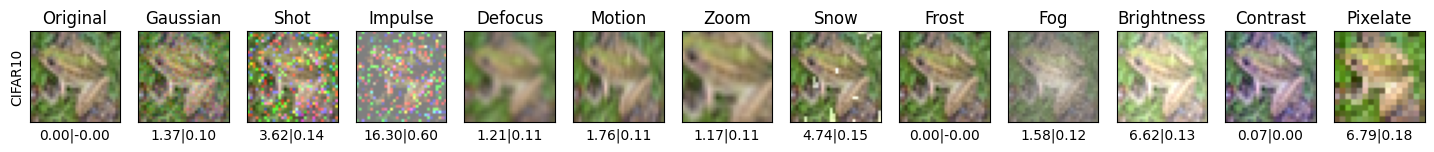

In [ ]:
# Helper functions
# Unnormalize the original and noisy images before displaying them
def unnormalize(np_image):
    return np_image * 0.5 + 0.5

# Original image
image = images[0]

# Create a PerturbationRGB object
perturbationRGB = PerturbationRGB(pixel_range=(-1, 1))

image = images[0]
#
original_label = get_distances_RGB_labels(image, image)
# Add Gaussian Noise
image_gaussian_noise = perturbationRGB.add_gaussian_noise(image, mean=0.0, std=0.4)
image_gaussian_noise_label = get_distances_RGB_labels(image, image_gaussian_noise)

# Convert the normalized image tensor to a NumPy array
image = image.numpy().transpose(1, 2, 0)  # Convert to HWC format

###################
# PERTURBATIONS
###################

# Create a Perturbation object and apply Gaussian noise
perturbationRGB = PerturbationRGB(pixel_range=(-1, 1))

# 1. Add Gaussian Noise
image_gaussian_noise = perturbationRGB.add_gaussian_noise(image, mean=0, std=0.1)
image_gaussian_noise_label = get_distances_RGB_labels(image, image_gaussian_noise)

# 2. Add Shot Noise
image_shot_noise = perturbationRGB.add_shot_noise(image, intensity=0.1)
image_shot_noise_label = get_distances_RGB_labels(image, image_shot_noise)

# 3. Impulse noise
image_impulse_noise = perturbationRGB.add_impulse_noise(image, density=0.1, intensity=1)
image_impulse_noise_label = get_distances_RGB_labels(image, image_impulse_noise)

# 4. Defocus blur
image_defocus_blur = perturbationRGB.add_defocus_blur(image, kernel_size=3, blur_amount=1.0)
image_defocus_blur_label = get_distances_RGB_labels(image, image_defocus_blur)

# 5. Motion blur
image_motion_blur = perturbationRGB.add_motion_blur(image, kernel_size=3, angle=0, direction=(1, 0))
image_motion_blur_label = get_distances_RGB_labels(image, image_motion_blur)

# 6. Zoom blur
image_zoom_blur = perturbationRGB.clipped_zoom(image, zoom_factor=1.5)
image_zoom_blur_label = get_distances_RGB_labels(image, image_zoom_blur)

# 7. Add snow
image_snow = perturbationRGB.add_snow(image, snow_level=0.85, snow_color=(1, 1, 1), blur_kernel_size=5, blur_sigma=1.0)
image_snow_label = get_distances_RGB_labels(image, image_snow)

# 8. Add frost
image_frost = perturbationRGB.add_frost(image, frost_level=0.5, frost_sigma=1.0, frost_threshold=0.1, blur_kernel_size=5, blur_sigma=1.0)
image_frost_label = get_distances_RGB_labels(image, image_frost)

# 9. Add fog
image_fog = perturbationRGB.add_fog(image, fog_level=0.5, fog_density=0.5)
image_fog_label = get_distances_RGB_labels(image, image_fog)

# 10. Add brightness
image_brightness = perturbationRGB.add_brightness(image, brightness=0.5)
image_brightness_label = get_distances_RGB_labels(image, image_brightness)

# 11. Add contrast
image_contrast = perturbationRGB.add_contrast(image, contrast_level=0.1)
image_contrast_label = get_distances_RGB_labels(image, image_contrast)

# 12. Add pixelation
image_pixelate = perturbationRGB.pixelate(image, factor=2)
image_pixelate_label = get_distances_RGB_labels(image, image_pixelate)

########################
# DISPLAY
########################

# Display the original and noisy images side by side
fig, axs = plt.subplots(1, 13, figsize=(18, 3))

# 1. Original
axs[0].imshow(unnormalize(image))
axs[0].set_title('Original')
axs[0].set_xlabel(original_label)
axs[0].set_ylabel('CIFAR10')
axs[0].set_xticks([])
axs[0].set_yticks([])

# 2. Gaussian Noise
axs[1].imshow(unnormalize(image_gaussian_noise))
axs[1].set_title('Gaussian')
axs[1].set_xlabel(image_gaussian_noise_label)
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])

# 3. Shot Noise
axs[2].imshow(unnormalize(image_shot_noise))
axs[2].set_title("Shot")
axs[2].set_xlabel(image_shot_noise_label)
axs[2].set_ylabel('')
axs[2].set_xticks([])
axs[2].set_yticks([])

# 4. Impulse Noise
axs[3].imshow(unnormalize(image_impulse_noise))
axs[3].set_title("Impulse")
axs[3].set_xlabel(image_impulse_noise_label)
axs[3].set_ylabel('')
axs[3].set_xticks([])
axs[3].set_yticks([])

# 5. Defocus Blur
axs[4].imshow(unnormalize(image_defocus_blur))
axs[4].set_title("Defocus")
axs[4].set_xlabel(image_defocus_blur_label)
axs[4].set_ylabel('')
axs[4].set_xticks([])
axs[4].set_yticks([])

# 6. Motion Blur
axs[5].imshow(unnormalize(image_motion_blur))
axs[5].set_title("Motion")
axs[5].set_xlabel(image_motion_blur_label)
axs[5].set_ylabel('')
axs[5].set_xticks([])
axs[5].set_yticks([])

# 7. Zoom Blur
axs[6].imshow(unnormalize(image_zoom_blur))
axs[6].set_title("Zoom")
axs[6].set_xlabel(image_zoom_blur_label)
axs[6].set_ylabel('')
axs[6].set_xticks([])
axs[6].set_yticks([])

# 8. Snow
axs[7].imshow(unnormalize(image_snow))
axs[7].set_title("Snow")
axs[7].set_xlabel(image_snow_label)
axs[7].set_ylabel('')
axs[7].set_xticks([])
axs[7].set_yticks([])

# 9. Frost
axs[8].imshow(unnormalize(image_frost))
axs[8].set_title("Frost")
axs[8].set_xlabel(image_frost_label)
axs[8].set_ylabel('')
axs[8].set_xticks([])
axs[8].set_yticks([])

# 10. Fog
axs[9].imshow(unnormalize(image_fog))
axs[9].set_title("Fog")
axs[9].set_xlabel(image_fog_label)
axs[9].set_ylabel('')
axs[9].set_xticks([])
axs[9].set_yticks([])

# 11. Brightness
axs[10].imshow(unnormalize(image_brightness))
axs[10].set_title("Brightness")
axs[10].set_xlabel(image_brightness_label)
axs[10].set_ylabel('')
axs[10].set_xticks([])
axs[10].set_yticks([])

# 12. Contrast
axs[11].imshow(unnormalize(image_contrast))
axs[11].set_title("Contrast")
axs[11].set_xlabel(image_contrast_label)
axs[11].set_ylabel('')
axs[11].set_xticks([])
axs[11].set_yticks([])

# 13. Pixelate
axs[12].imshow(unnormalize(image_pixelate))
axs[12].set_title("Pixelate")
axs[12].set_xlabel(image_pixelate_label)
axs[12].set_ylabel('')
axs[12].set_xticks([])
axs[12].set_yticks([])
plt.show()



# Apply RGB perturbations - refactored

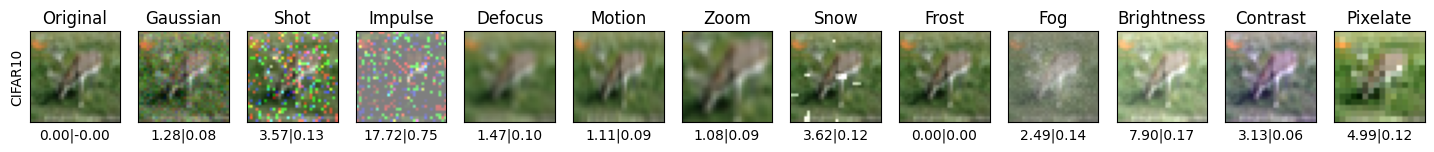

In [22]:
# Helper functions
# Unnormalize the original and noisy image_rgbs before displaying them
def unnormalize(np_image):
    return np_image * 0.5 + 0.5

# Original image
image_rgb = images_rgb[0]

# Create a PerturbationRGB object
perturbationRGB = PerturbationRGB(pixel_range=(-1, 1))

# 0. No noise
original_label = get_distances_RGB_labels(image_rgb, image_rgb)
# Add Gaussian Noise
image_rgb_gaussian_noise = perturbationRGB.add_gaussian_noise(image_rgb, mean=0.0, std=0.4)
image_rgb_gaussian_noise_label = get_distances_RGB_labels(image_rgb, image_rgb_gaussian_noise)

# Convert the normalized image_rgb tensor to a NumPy array
image_rgb = image_rgb.numpy().transpose(1, 2, 0)  # Convert to HWC format

###################
# PERTURBATIONS
###################

# Create a Perturbation object and apply Gaussian noise
perturbationRGB = PerturbationRGB(pixel_range=(-1, 1))

# 1. Add Gaussian Noise
image_rgb_gaussian_noise = perturbationRGB.add_gaussian_noise(image_rgb, mean=0, std=0.1)
image_rgb_gaussian_noise_label = get_distances_RGB_labels(image_rgb, image_rgb_gaussian_noise)

# 2. Add Shot Noise
image_rgb_shot_noise = perturbationRGB.add_shot_noise(image_rgb, intensity=0.1)
image_rgb_shot_noise_label = get_distances_RGB_labels(image_rgb, image_rgb_shot_noise)

# 3. Impulse noise
image_rgb_impulse_noise = perturbationRGB.add_impulse_noise(image_rgb, density=0.1, intensity=1)
image_rgb_impulse_noise_label = get_distances_RGB_labels(image_rgb, image_rgb_impulse_noise)

# 4. Defocus blur
image_rgb_defocus_blur = perturbationRGB.add_defocus_blur(image_rgb, kernel_size=3, blur_amount=1.0)
image_rgb_defocus_blur_label = get_distances_RGB_labels(image_rgb, image_rgb_defocus_blur)

# 5. Motion blur
image_rgb_motion_blur = perturbationRGB.add_motion_blur(image_rgb, kernel_size=3, angle=0, direction=(1, 0))
image_rgb_motion_blur_label = get_distances_RGB_labels(image_rgb, image_rgb_motion_blur)

# 6. Zoom blur
image_rgb_zoom_blur = perturbationRGB.clipped_zoom(image_rgb, zoom_factor=1.5)
image_rgb_zoom_blur_label = get_distances_RGB_labels(image_rgb, image_rgb_zoom_blur)

# 7. Add snow
image_rgb_snow = perturbationRGB.add_snow(image_rgb, snow_level=0.85, snow_color=(1, 1, 1), blur_kernel_size=5, blur_sigma=1.0)
image_rgb_snow_label = get_distances_RGB_labels(image_rgb, image_rgb_snow)

# 8. Add frost
image_rgb_frost = perturbationRGB.add_frost(image_rgb, frost_level=0.5, frost_sigma=1.0, frost_threshold=0.1, blur_kernel_size=5, blur_sigma=1.0)
image_rgb_frost_label = get_distances_RGB_labels(image_rgb, image_rgb_frost)

# 9. Add fog
image_rgb_fog = perturbationRGB.add_fog(image_rgb, fog_level=0.5, fog_density=0.5)
image_rgb_fog_label = get_distances_RGB_labels(image_rgb, image_rgb_fog)

# 10. Add brightness
image_rgb_brightness = perturbationRGB.add_brightness(image_rgb, brightness=0.5)
image_rgb_brightness_label = get_distances_RGB_labels(image_rgb, image_rgb_brightness)

# 11. Add contrast
image_rgb_contrast = perturbationRGB.add_contrast(image_rgb, contrast_level=0.1)
image_rgb_contrast_label = get_distances_RGB_labels(image_rgb, image_rgb_contrast)

# 12. Add pixelation
image_rgb_pixelate = perturbationRGB.pixelate(image_rgb, factor=2)
image_rgb_pixelate_label = get_distances_RGB_labels(image_rgb, image_rgb_pixelate)

########################
# DISPLAY
########################

# Display the original and noisy images side by side
fig, axs = plt.subplots(1, 13, figsize=(18, 3))

# 1. Original
axs[0].imshow(unnormalize(image_rgb))
axs[0].set_title('Original')
axs[0].set_xlabel(original_label)
axs[0].set_ylabel('CIFAR10')
axs[0].set_xticks([])
axs[0].set_yticks([])

# 2. Gaussian Noise
axs[1].imshow(unnormalize(image_rgb_gaussian_noise))
axs[1].set_title('Gaussian')
axs[1].set_xlabel(image_rgb_gaussian_noise_label)
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])

# 3. Shot Noise
axs[2].imshow(unnormalize(image_rgb_shot_noise))
axs[2].set_title("Shot")
axs[2].set_xlabel(image_rgb_shot_noise_label)
axs[2].set_ylabel('')
axs[2].set_xticks([])
axs[2].set_yticks([])

# 4. Impulse Noise
axs[3].imshow(unnormalize(image_rgb_impulse_noise))
axs[3].set_title("Impulse")
axs[3].set_xlabel(image_rgb_impulse_noise_label)
axs[3].set_ylabel('')
axs[3].set_xticks([])
axs[3].set_yticks([])

# 5. Defocus Blur
axs[4].imshow(unnormalize(image_rgb_defocus_blur))
axs[4].set_title("Defocus")
axs[4].set_xlabel(image_rgb_defocus_blur_label)
axs[4].set_ylabel('')
axs[4].set_xticks([])
axs[4].set_yticks([])

# 6. Motion Blur
axs[5].imshow(unnormalize(image_rgb_motion_blur))
axs[5].set_title("Motion")
axs[5].set_xlabel(image_rgb_motion_blur_label)
axs[5].set_ylabel('')
axs[5].set_xticks([])
axs[5].set_yticks([])

# 7. Zoom Blur
axs[6].imshow(unnormalize(image_rgb_zoom_blur))
axs[6].set_title("Zoom")
axs[6].set_xlabel(image_rgb_zoom_blur_label)
axs[6].set_ylabel('')
axs[6].set_xticks([])
axs[6].set_yticks([])

# 8. Snow
axs[7].imshow(unnormalize(image_rgb_snow))
axs[7].set_title("Snow")
axs[7].set_xlabel(image_rgb_snow_label)
axs[7].set_ylabel('')
axs[7].set_xticks([])
axs[7].set_yticks([])

# 9. Frost
axs[8].imshow(unnormalize(image_rgb_frost))
axs[8].set_title("Frost")
axs[8].set_xlabel(image_rgb_frost_label)
axs[8].set_ylabel('')
axs[8].set_xticks([])
axs[8].set_yticks([])

# 10. Fog
axs[9].imshow(unnormalize(image_rgb_fog))
axs[9].set_title("Fog")
axs[9].set_xlabel(image_rgb_fog_label)
axs[9].set_ylabel('')
axs[9].set_xticks([])
axs[9].set_yticks([])

# 11. Brightness
axs[10].imshow(unnormalize(image_rgb_brightness))
axs[10].set_title("Brightness")
axs[10].set_xlabel(image_rgb_brightness_label)
axs[10].set_ylabel('')
axs[10].set_xticks([])
axs[10].set_yticks([])

# 12. Contrast
axs[11].imshow(unnormalize(image_rgb_contrast))
axs[11].set_title("Contrast")
axs[11].set_xlabel(image_rgb_contrast_label)
axs[11].set_ylabel('')
axs[11].set_xticks([])
axs[11].set_yticks([])

# 13. Pixelate
axs[12].imshow(unnormalize(image_rgb_pixelate))
axs[12].set_title("Pixelate")
axs[12].set_xlabel(image_rgb_pixelate_label)
axs[12].set_ylabel('')
axs[12].set_xticks([])
axs[12].set_yticks([])
plt.show()



# Render/Plot grayscale + RGB

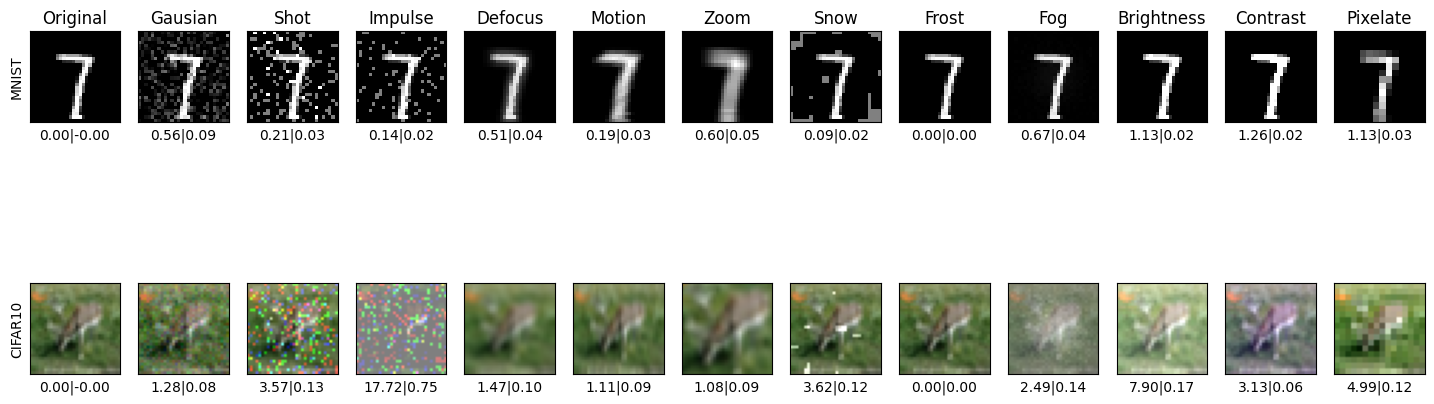

In [56]:
# Display the original and noisy images
# fig, axs = plt.subplots(1, 13, figsize=(18, 3))

# Create a figure with 13 columns and 2 rows
fig, axs = plt.subplots(2, 13, figsize=(18, 6))
#fig.tight_layout()

# Flatten the axs array to simplify indexing
axs = axs.flatten()

########################
# Grayscale Row
########################

# 1. original
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original')
axs[0].set_xlabel(original_label)
axs[0].set_ylabel('MNIST')
axs[0].set_xticks([])
axs[0].set_yticks([])

# 2. Gaussian Noise
axs[1].imshow(image_gaussian_noise, cmap='gray')
axs[1].set_title('Gausian')
axs[1].set_xlabel(image_gaussian_noise_label)
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])

# 3. Shot Noise
axs[2].imshow(image_shot_noise, cmap='gray')
axs[2].set_title('Shot')
axs[2].set_xlabel(image_shot_noise_label)
axs[2].set_ylabel('')
axs[2].set_xticks([])
axs[2].set_yticks([])

# 4. Impulse Noise
axs[3].imshow(image_impulse_noise, cmap='gray')
axs[3].set_title('Impulse')
axs[3].set_xlabel(image_impulse_noise_label)
axs[3].set_ylabel('')
axs[3].set_xticks([])
axs[3].set_yticks([])

# 5. Defocus Blur
axs[4].imshow(image_defocus_blur, cmap='gray')
axs[4].set_title('Defocus')
axs[4].set_xlabel(image_defocus_blur_label)
axs[4].set_ylabel('')
axs[4].set_xticks([])
axs[4].set_yticks([])

# 4. Motion Blur
axs[5].imshow(image_motion_blur, cmap='gray')
axs[5].set_title('Motion')
axs[5].set_xlabel(image_motion_blur_label)
axs[5].set_ylabel('')
axs[5].set_xticks([])
axs[5].set_yticks([])

# 5. Zoom Blur
axs[6].imshow(image_zoom_blur, cmap='gray')
axs[6].set_title('Zoom')
axs[6].set_xlabel(image_zoom_blur_label)
axs[6].set_ylabel('')
axs[6].set_xticks([])
axs[6].set_yticks([])

# 6. Snow
axs[7].imshow(image_snow, cmap='gray')
axs[7].set_title('Snow')
axs[7].set_xlabel(image_snow_label)
axs[7].set_ylabel('')
axs[7].set_xticks([])
axs[7].set_yticks([])

# 7. Frost
axs[8].imshow(image_frost, cmap='gray')
axs[8].set_title('Frost')
axs[8].set_xlabel(image_frost_label)
axs[8].set_ylabel('')
axs[8].set_xticks([])
axs[8].set_yticks([])

# 8. Fog
axs[9].imshow(image_fog, cmap='gray')
axs[9].set_title('Fog')
axs[9].set_xlabel(image_fog_label)
axs[9].set_ylabel('')
axs[9].set_xticks([])
axs[9].set_yticks([])

# 9. Brightness
axs[10].imshow(image_brightness, cmap='gray')
axs[10].set_title('Brightness')
axs[10].set_xlabel(image_brightness_label)
axs[10].set_ylabel('')
axs[10].set_xticks([])
axs[10].set_yticks([])

# 10. Contrast
axs[11].imshow(image_contrast, cmap='gray')
axs[11].set_title('Contrast')
axs[11].set_xlabel(image_contrast_label)
axs[11].set_ylabel('')
axs[11].set_xticks([])
axs[11].set_yticks([])

# 11. Pixelate
axs[12].imshow(image_pixelate, cmap='gray')
axs[12].set_title('Pixelate')
axs[12].set_xlabel(image_pixelate_label)
axs[12].set_ylabel('')
axs[12].set_xticks([])
axs[12].set_yticks([])

########################
# RGB Row
########################

# 1. Original
axs[13].imshow(unnormalize(image_rgb))
axs[13].set_title('')
axs[13].set_xlabel(original_label)
axs[13].set_ylabel('CIFAR10')
axs[13].set_xticks([])
axs[13].set_yticks([])

# 2. Gaussian Noise
axs[14].imshow(unnormalize(image_rgb_gaussian_noise))
axs[14].set_title('')
axs[14].set_xlabel(image_rgb_gaussian_noise_label)
axs[14].set_ylabel('')
axs[14].set_xticks([])
axs[14].set_yticks([])

# 3. Shot Noise
axs[15].imshow(unnormalize(image_rgb_shot_noise))
axs[15].set_title('')
axs[15].set_xlabel(image_rgb_shot_noise_label)
axs[15].set_ylabel('')
axs[15].set_xticks([])
axs[15].set_yticks([])

# 4. Impulse Noise
axs[16].imshow(unnormalize(image_rgb_impulse_noise))
axs[16].set_title('')
axs[16].set_xlabel(image_rgb_impulse_noise_label)
axs[16].set_ylabel('')
axs[16].set_xticks([])
axs[16].set_yticks([])

# 5. Defocus Blur
axs[17].imshow(unnormalize(image_rgb_defocus_blur))
axs[17].set_title('')
axs[17].set_xlabel(image_rgb_defocus_blur_label)
axs[17].set_ylabel('')
axs[17].set_xticks([])
axs[17].set_yticks([])

# 6. Motion Blur
axs[18].imshow(unnormalize(image_rgb_motion_blur))
axs[18].set_title('')
axs[18].set_xlabel(image_rgb_motion_blur_label)
axs[18].set_ylabel('')
axs[18].set_xticks([])
axs[18].set_yticks([])

# 7. Zoom Blur
axs[19].imshow(unnormalize(image_rgb_zoom_blur))
axs[19].set_title('')
axs[19].set_xlabel(image_rgb_zoom_blur_label)
axs[19].set_ylabel('')
axs[19].set_xticks([])
axs[19].set_yticks([])

# 8. Snow
axs[20].imshow(unnormalize(image_rgb_snow))
axs[20].set_title('')
axs[20].set_xlabel(image_rgb_snow_label)
axs[20].set_ylabel('')
axs[20].set_xticks([])
axs[20].set_yticks([])

# 9. Frost
axs[21].imshow(unnormalize(image_rgb_frost))
axs[21].set_title('')
axs[21].set_xlabel(image_rgb_frost_label)
axs[21].set_ylabel('')
axs[21].set_xticks([])
axs[21].set_yticks([])

# 10. Fog
axs[22].imshow(unnormalize(image_rgb_fog))
axs[22].set_title('')
axs[22].set_xlabel(image_rgb_fog_label)
axs[22].set_ylabel('')
axs[22].set_xticks([])
axs[22].set_yticks([])

# 11. Brightness
axs[23].imshow(unnormalize(image_rgb_brightness))
axs[23].set_title('')
axs[23].set_xlabel(image_rgb_brightness_label)
axs[23].set_ylabel('')
axs[23].set_xticks([])
axs[23].set_yticks([])

# 12. Contrast
axs[24].imshow(unnormalize(image_rgb_contrast))
axs[24].set_title('')
axs[24].set_xlabel(image_rgb_contrast_label)
axs[24].set_ylabel('')
axs[24].set_xticks([])
axs[24].set_yticks([])

# 13. Pixelate
axs[25].imshow(unnormalize(image_rgb_pixelate))
axs[25].set_title('')
axs[25].set_xlabel(image_rgb_pixelate_label)
axs[25].set_ylabel('')
axs[25].set_xticks([])
axs[25].set_yticks([])

# Adjust spacing between subplots
#fig.subplots_adjust(wspace=0.2)

plt.savefig('MNIST_CIFAR10_Perturbations.png', dpi=300, bbox_inches='tight')

plt.show()



# Import VOCSegmentation dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the root directory for the dataset
root = './data/VOCSegmentation'

# Define a custom transform to resize the images to a fixed size before converting them to tensors
class ToTensorAndResize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image):
        image = transforms.Resize(self.size, interpolation=transforms.InterpolationMode.BILINEAR)(image)
        return transforms.ToTensor()(image)

# Download the dataset
testset = torchvision.datasets.VOCSegmentation(root=root, year='2012', image_set='val', transform=ToTensorAndResize(size=(512, 512)), download=False)

# Define the data loader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Define the model and load the pre-trained weights
model = torchvision.models.segmentation.fcn_resnet101(pretrained=True)
model.eval()

# Define the device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the criterion for calculating the loss
criterion = torch.nn.CrossEntropyLoss()

# Test the model on the test set
running_loss = 0.0
total_accuracy = 0.0
with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data['image'].to(device), data['label'].to(device)
        outputs = model(inputs)['out']
        loss = criterion(outputs, labels.long())
        running_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        total_accuracy += (predicted == labels).sum().item() / (inputs.shape[0] * inputs.shape[1] * inputs.shape[2])
    print(f'Average loss: {running_loss / len(testloader)}')
    print(f'Average accuracy: {total_accuracy / len(testloader)}')


RuntimeError: ignored

In [ ]:
import torch.utils.data
import torchvision.datasets as datasets

# Define the root directory for the dataset
root = './data/COCO'

# Download the training and test sets
datasets.CocoDetection(root=root, annFile='./annotations/train.json', download=True)
datasets.CocoDetection(root=root, annFile='./annotations/test.json', download=True)

# Define the data loaders for the training and test sets
trainset = datasets.CocoDetection(root=root, annFile='./annotations/train.json', transform=None)
testset = datasets.CocoDetection(root=root, annFile='./annotations/test.json', transform=None)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


# Print the number of images in each set
print(f'Number of training images: {len(trainset)}')
print(f'Number of test images: {len(testset)}')


TypeError: ignored

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Get one image from the dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)
image = images[0]

# Convert the normalized image tensor to a NumPy array
image_np = image.numpy().transpose(1, 2, 0)  # Convert to HWC format

# Create a Perturbation object and apply Gaussian noise
perturbation = Perturbation(pixel_range=(-1, 1))
noisy_image_np = perturbation.add_gaussian_noise(image_np, mean=0, std=0.1)

# Unnormalize the original and noisy images before displaying them
def unnormalize(np_image):
    return np_image * 0.5 + 0.5

print("Original Image:")
imshow(unnormalize(image_np))

print("Noisy Image:")
imshow(unnormalize(noisy_image_np))


Files already downloaded and verified


ValueError: ignored